In [2]:
import os 

fname ="jena_climate_2009_2016.csv"

f = open(fname) #open and read a file
data = f.read() #this makes it a string
f.close

lines = data.split("\n")
header = lines[0].split(",")
lines = lines [1:]

print(header)
print(len(header))
print(len(lines))
print(lines[0])
print(lines[1])
print(lines[2])
print(type(lines[0]))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15
420551
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
<class 'str'>


In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))


for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i, :] = values

print(float_data.shape)

(420551, 14)


In [1]:
#import numpy as np

#float_data = np.zeros((len(lines), len(header)-1)) #using previous to define shape row = sample, columns = features

#for i, line in enumerate(lines):
#    values = [float(x) for x in line.split(",")[1:]] #floating everything except time
#    float_data[i,:] = values

#print(float_data.shape)


#wrong, do not run

NameError: name 'lines' is not defined

In [4]:
print(float_data.shape[0])

420551


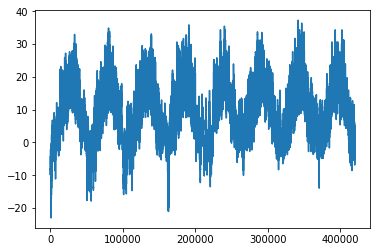

In [7]:
import matplotlib.pyplot as plt

temp = float_data[:,1]
plt.plot(range(len(temp)), temp)

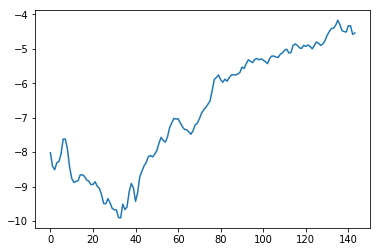

In [8]:
plt.plot(range(144),temp[:144])

In [9]:
mean = float_data[:200000].mean(axis =0) #computes 14 means
print(mean.shape) #just a test, not required

float_data -=mean
std = float_data[:200000].std(axis=0)
float_data /= std

(14,)


In [11]:
lookback = 720 # 5 days in the past
step = 6 # one sample per hour
delay = 144 # target 24 h in the future


def generator(
    data,
    lookback, delay,
    min_index, max_index,
    shuffle=False,      #shuffle in phase of Neural Network in training . Avoid bias in terms of patterns in detection/training
    batch_size=128,
    step=6):

    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback # TODO redundant?
    while True:

        if shuffle:
            rows = np.random.randint(
                min_index + lookback,
                max_index,
                batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets

#generator = generator(float_data, lookback, delay, 0:200000, true, 1,6)
#    data = float_data,
#    lookback= lookback,
#    delay=delay
#)        
        
#next(generator(float_data, lookback, delay, 0:200000, true, 1,6))
next(generator(float_data, lookback, delay, 0,200000))[0].shape

(128, 120, 14)

In [12]:
lookback = 1440
batch_size = 128
step = 6
delay = 720

In [20]:
#for training, it shuffles it. 
#parameterization
#look into the past and how far to predict in the future


train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [21]:
from keras import models,layers, optimizers

model = models.Sequential()

model.add(layers.Flatten(    #Flatten reduces data to 1D
    input_shape=(lookback // step,float_data.shape[-1])
))

model.add(layers.Dense(32,activation="relu"))
model.add(layers.Dense(1))


model.summary()

model.compile(
    optimizer = optimizers.RMSprop(),
    loss ="mse",
    metrics = ["mae"]
    
)

history = model.fit_generator( #generator approach
    train_gen,
    steps_per_epoch =500,
    epochs = 20,
    validation_data =val_gen,
    validation_steps = val_steps //100

)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 57s 113ms/step - loss: 3.3282 - mean_absolute_error: 1.2020 - val_loss: 0.5052 - val_mean_absolute_error: 0.5683
Epoch 2/20
500/500 [==============================] - 56s 113ms/step - loss: 0.6663 - mean_absolute_error: 0.5928 - val_loss: 0.5619 - val_mean_absolute_error: 0.6070
Epoch 3/20
500/500 [==============================] - 57s 113ms/st

In [ ]:
model = models.Sequential()
model.add(layers.GRU(
    32,
    input_shape=(None,float_data.shape[-1])
))
          
model.add(layers.Dense(1))
          
model.compile(
    optimizer = optimizers.RMSprop(),
    loss ="mse",
    metrics = ["mae"]
    
)

history = model.fit_generator( #generator approach
    train_gen,
    steps_per_epoch =500,
    epochs = 20,
    validation_data =val_gen,
    validation_steps = val_steps //100

)

Epoch 1/20
365/500 [====================>.........] - ETA: 2:42 - loss: 0.3193 - mean_absolute_error: 0.4475